# Introduction

This project run top-to-bottom produces all of the figures and other data found in the supplementary and manuscript which pertain to the atomistics simulations. On our machine this took ~136 core hours, the vast majority of which goes to a few coupled Monte Carlo-Molecular Dynamics (MCMD) Lammps runs (with an MEAM potential, for which the Lammps fix is not optimized -- those with an EAM potential also ran but are much faster).

Together with the code in `pyiron_FeAl` you should, up to changes based on the stochastic nature of running MD and working with solid solutions, be able to reproduce everything.

There will be some annotation through the notebook, and the code has some structure, but be a bit forgiving. At least you've got it. 

# Setup

**WARNING:** The one system-specific variable here is the `server` below. We never use more than a single core, but some of the MC/MD calculations take a few days, so it's advisable to get your own pyiron installation running on a remote cluster and set this server attribute to be appropriate for your machine.

In [1]:
SERVER = 'cm'

In [2]:
from pyiron_feal import Project
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
from scipy.constants import physical_constants
KB = physical_constants['Boltzmann constant in eV/K'][0]

In [3]:
pr = Project('projects/research')

# Emperical potentail evaluation

First let's see which potentials give BCC stability. We'll probe the 0K energy of our phases of interest.

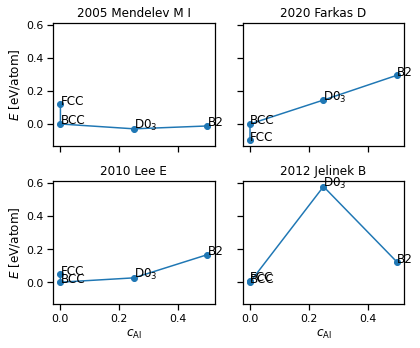

In [4]:
n_potls = len(pr.input.potentials)
fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True, figsize=(6,5))

for potl_index, potl_name in enumerate(pr.input.potentials):
    ax = pr.zerok.plot_phases_0K(
        potl_index=potl_index, 
        ax=axes.flatten()[potl_index],
        label_x=potl_index in [2, 3],
        label_y=potl_index in [0, 2]
    )
    ax.set_title(pr.lammps_potl_to_string(potl_name))
fig.tight_layout()
fig.savefig('writeup/supplementary/figures/zerok_phases.eps', format='eps')

The Farkas and Jelinek potentials don't give clear BCC dominance, so we'll just ignore them from here.

# Solid solution

Next let's probe a little deeper by adding Al antisites in the BCC Fe. We'll do this randomly for a bunch of configurations and look at the 0K potential energy as a function of Al concentration

In [5]:
def plot_phase_energy_with_config_entropy(filename, with_layers_and_columns=True, both_potentials=True, use_title=True):
    # Columnar
    reps = np.arange(1, 6, dtype=int)
    columnar_c_Al = [1 / len(pr.create.structure.FeAl.columnar_b2(planar_repeats=r)) for r in reps]  # 1 / (2 * reps**2)

    # Layered
    layers = np.arange(1, 10, dtype=int)
    layered_c_Al = [1 / len(pr.create.structure.FeAl.layered_Al(layers=l)) for l in layers]

    # Solid solution
    c_Al_targets = np.unique(np.concatenate((
        np.linspace(0, 0.1, 3),
        np.linspace(0.1, 0.2, 11),
        np.linspace(0.2, 0.25, 3)
    )))
    deg = 3
    c_range = np.linspace(0, 0.25, 200)

    if both_potentials:
        fig, axes = plt.subplots(nrows=2, figsize=(5, 9))
        potl_indices = [0, 2]
    else:
        fig, axis = plt.subplots()
        axes = [axis]
        potl_indices = [2]
    for potl_index, ax in zip(potl_indices, axes):
        e_ref =  pr.zerok.get_bcc_peratom_energy(potl_index=potl_index)

        columnar_energy = np.array([
            pr.zerok.get_columnar_b2_peratom_energy(planar_repeats=r, potl_index=potl_index) 
            for r in reps
        ]) - e_ref

        layered_energy = np.array([
            pr.zerok.get_layered_peratom_energy(layers=l, potl_index=potl_index) 
            for l in layers
        ]) - e_ref

        concentrations, solution_energies = pr.zerok.get_bcc_solution_energies(
            c_Al_targets, 
            repeat=3, 
            n_trials=10,
            potl_index=potl_index
        )
        means, stds = solution_energies.mean(axis=-1) - e_ref, solution_energies.std(axis=-1)
        S = pr.zerok.S_ideal_mixing(c_Al_targets)
        poly = np.poly1d(np.polyfit(concentrations, means, deg=deg))

        ax = pr.zerok.plot_phases_0K(
            relative=True, 
            potl_index=potl_index,
            ax=ax
        )
        if with_layers_and_columns:
            ax.plot(columnar_c_Al, columnar_energy, label='Columnar', marker='o', linestyle='--')
            ax.plot(layered_c_Al, layered_energy, label='Layered', marker='s', linestyle='--')
        ax.errorbar(
            concentrations,
            means,
            yerr=1.96*stds,  # std -> 95% confidence interval
            marker='<',
            linestyle=':',
            label='Solution 0K'
        )
        ax.errorbar(
            concentrations,
            means -523*S,
            yerr=1.96*stds,  # std -> 95% confidence interval
            marker='<',
            linestyle=':',
            label='Solution 523K'
        )
        ax.errorbar(
            concentrations,
            means -873*S,
            yerr=1.96*stds,  # std -> 95% confidence interval
            marker='>',
            linestyle=':',
            label='Solution 873K'
        )
        ax.axvline(0.18, color='k', linestyle='--')
        if use_title:
            ax.set_title(pr.input.potentials[potl_index])
        ax.legend()
    fig.tight_layout()
    fig.savefig(filename, format='eps')    
    plt.show();

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


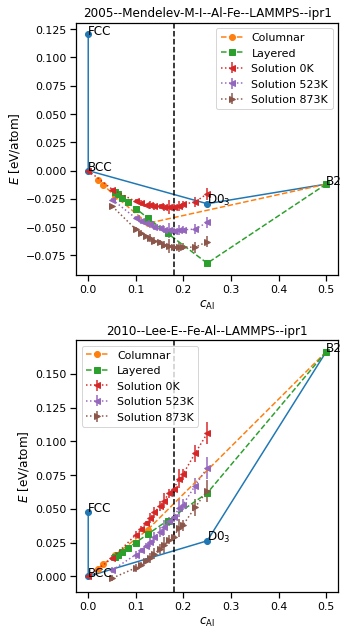

In [6]:
plot_phase_energy_with_config_entropy('writeup/supplementary/figures/expanded_0K_phases.eps')

In the process of doing this research, we discovered that the Mendelev potential actually has a strong preference for this ordered phase of Al columns and planes. We'll run with it anyhow (i.e. the expensive MCMD calculations had already been done...) but it's not very promising that we'll see D03!

The Lee potential doesn't have this problem. The Al solubility seems a little bit low, and at 18\% Al we only expect an measurable Al concentration in BCC phase at the highest temperature. However, this is at least qualitatively correct -- not bad for an empirical potential!

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


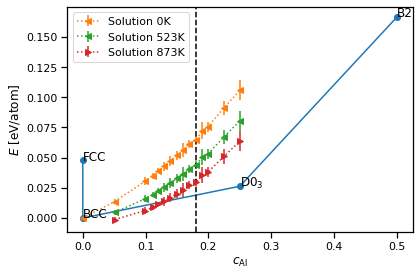

In [7]:
plot_phase_energy_with_config_entropy(
    'writeup/figures/expanded_0K_phases.eps', 
    with_layers_and_columns=False,
    both_potentials=False,
    use_title=False
)  # Streamlined a bit for the main manuscript

In [8]:
solid_solution_size = len(pr.inspect('min_p2_bcc_r3_t4_P0_cAl5_09')['output/generic/positions'][-1])
solid_solution_size

432

Let's visualize some of these structures (Figs for the manuscripts were generated from here by hand with screenshots, sorry!)

In [9]:
pr.create.structure.FeAl.fcc().plot3d(view_plane=[1, 1, 1])

NGLWidget()

In [10]:
pr.create.structure.FeAl.bcc(repeat=3, c_Al=0.18).plot3d()

NGLWidget()

In [11]:
pr.create.structure.FeAl.d03().plot3d()

NGLWidget()

In [12]:
pr.create.structure.FeAl.b2().plot3d()

NGLWidget()

In [13]:
pr.create.structure.FeAl.columnar_b2(planar_repeats=3).repeat(2).plot3d()

NGLWidget()

In [14]:
pr.create.structure.FeAl.layered_Al(layers=3).repeat(3).plot3d()

NGLWidget()

# Finite temperature

Finally, let's introduce finite temperature by running variance constrained semi-grand-cannonical (VCSGC) MCMD. We'll use quite a strict variance constraint so that our nominal composition stays very close to the nominal experimental concentration of 18\%Al, and will run at both experimental temperatures for both the Mendelev and Lee potentials on a cube 4nm to each side -- smaller than the experimental APT tips, but the same ballpark.

In [15]:
mcmd_jobs = {}
potl_name = ['Mendelev', 'Lee']
for T in [523, 873]:
    for i, potl in enumerate([0, 2]):
        job = pr.create.job.mcmd.small_cube(
            temperature=T, 
            potl_index=potl,
            n_ionic_steps=1e5,
            n_print=1e4
        )
        job.server.queue = SERVER
        job.run()
        mcmd_jobs[f'{potl_name[i]} {T}K'] = job

2021-10-13 15:01:05,479 - pyiron_log - WARNING - The job mcmd_p0_cube_523K_cAl18_0_mu0_n100000_k10000 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2021-10-13 15:01:06,396 - pyiron_log - WARNING - The job mcmd_p2_cube_523K_cAl18_0_mu0_n100000_k10000 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2021-10-13 15:01:07,285 - pyiron_log - WARNING - The job mcmd_p0_cube_873K_cAl18_0_mu0_n100000_k10000 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2021-10-13 15:01:08,171 - pyiron_log - WARNING - The job mcmd_p2_cube_873K_cAl18_0_mu0_n100000_k10000 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


In [16]:
mcmd_jobs.keys()

dict_keys(['Mendelev 523K', 'Lee 523K', 'Mendelev 873K', 'Lee 873K'])

How well converged are these? One rough estimate is just to look at the energy -- if it has stabilized and is just fluctuating then the atoms have probably ordered themselves in a pretty favourable way.

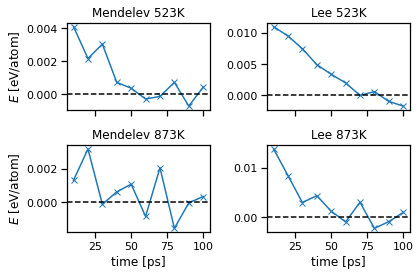

In [17]:
fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True)
for ax, (title, job) in zip(axes.flatten(), mcmd_jobs.items()):
    N = len(job.structure)
    time = (1 + np.arange(len(job.output.energy_pot[1:]))) * 10  # ps
    mean_last_5 = job.output.energy_pot[-5:].mean() / N
    ax.plot(time, (job.output.energy_pot[1:] / N) - mean_last_5, marker='x')
    ax.axhline(0, color='k', linestyle='--')
    ax.set_title(title) #job.potential['Name'].values[0])
axes[1, 0].set_xlabel('time [ps]')
axes[1, 1].set_xlabel('time [ps]')
axes[0, 0].set_ylabel('$E$ [eV/atom]') 
axes[1, 0].set_ylabel('$E$ [eV/atom]') 
fig.tight_layout()
fig.savefig(
    'writeup/supplementary/figures/energy_conv.eps', 
    format='eps'
)
plt.show()

By comparing the energy to the average of the last five frames, we can see a couple things: the hot simulations equilibrate faster, and the Lee potential equilibrates slower. Only the Lee potential at the cold temperature of 523K is a big red flag.

This behaviour actually makes some sense -- if we go back to our 0K "phase diagram" we can see that this potential probably prefers phase separation in both these cases, but for the colder temperature it wants almost 0\% Al in the BCC solution! We started the simulation with 18\%Al solid solution, so it's not surprising that it takes a long time to collect all that into D03. At the higher temperature we can expect the solid solution to accept something in the very rough neighbourhood of 10\%Al, which is not nearly so much work. We'll come back to this topic again at the end of the notebook.

Let's peek at the final states of the systems. (We'll remap the final chemistry back onto the initial 0K unperturbed lattice sites.)

In [18]:
pr.mcmd_sro.remap_species(mcmd_jobs['Mendelev 523K']).plot3d()

NGLWidget()

In [19]:
pr.mcmd_sro.remap_species(mcmd_jobs['Mendelev 873K']).plot3d()

NGLWidget()

For the Mendelev potential, it's actually not too hard to see by simple visual inspection the formation of these rod-like Al structures our 0K calculations predicted were favourable.

In [20]:
pr.mcmd_sro.remap_species(mcmd_jobs['Lee 523K']).plot3d()

NGLWidget()

In [21]:
pr.mcmd_sro.remap_species(mcmd_jobs['Lee 873K']).plot3d()

NGLWidget()

# Cluster analysis

Finally, let's quantify the cluster formation. Since we don't have any vacancies and are not running hot/long enough to be worried about self-interstitial diffusion, we can assume we know the topology of our atoms. For our cluster analysis we'll keep things very simple and for each atom we'll compare it's immediate neighbourhood to all the symmetrically-equivalent D03 and B2 neighbourhoods. If at least some number of neighbours match the reference pattern for the D03 (B2) then we consider this a D03 (B2) atom! We can repeat this and do a breadth-first-search over the topology to build up clusters.

This approach has on degree of freedom: how many neighbours are needed to count as agreeing with the reference pattern? Too low a threshold and you will erroneously get giant "secondary phase clusters", but it's probably not fair to require *all* the neighbours to match -- after all, the secondary phases are allowed to contain antisite point defects as well! Below we'll play with a few values.

In [22]:
n_neigh = 14  # 8=1NN, 14=1+2NN
topology = mcmd_jobs['Mendelev 523K'].get_structure(0).get_neighbors(num_neighbors=n_neigh).indices
reference_environments = {
    ref: getattr(pr.mcmd_sro.reference_symbols.small_cube, ref)
    for ref in ['b2_0', 'b2_1', 'd03_0', 'd03_1', 'd03_2', 'd03_3']
}  # TODO: Better code between the attribute and the next method call
pr.mcmd_sro.define_clustering(
    topology=topology, 
    reference_environments=reference_environments, 
    threshold=11
)

In [119]:
clusters = {}
for threshold in [11, 12, 13]:
    clusters[threshold] = {}
    for name, job in mcmd_jobs.items():
        clusters[threshold][name] = {}
        clusters[threshold][name]['before'] = pr.mcmd_sro.cluster(
            job.get_structure(0).get_chemical_symbols(), 
            threshold=threshold
        )
        clusters[threshold][name]['after'] = pr.mcmd_sro.cluster(
            job.get_structure(-1).get_chemical_symbols(), 
            threshold=threshold
        )

In [136]:
def clipit(data, clip):
    return np.clip(data, 0, clip) if clip is not None else data

def plot_hist(ax, cluster, phase, binsize, clip=None, title=None, logy=True):
    before = clipit(getattr(cluster['before'], phase), clip)
    after = clipit(getattr(cluster['after'], phase), clip)
    biggest = np.amax(np.append(before, after))
    ax.hist(
        [before, after], 
        bins=np.arange(biggest + binsize, step=binsize), 
        label=['before', 'after']
    )
    if logy:
        ax.set_yscale('log')
    # ax.set_xscale('symlog')
    ax.set_title(title)
    return ax

def plot_histograms(potl_index, threshold=13, binsize=10, clip=160, title=None, logy=True):
    fig, axes = plt.subplots(
        ncols=2, 
        nrows=2, 
        sharey='col', 
        sharex='col'
    )
    potl_name = ['Mendelev', _, 'Lee']


    plot_hist(
        axes[0, 0],
        clusters[threshold][f'{potl_name[potl_index]} 523K'],
        'd03', binsize, clip=clip, #title='cold d03',
        logy=logy
    )
    plot_hist(
        axes[0, 1],
        clusters[threshold][f'{potl_name[potl_index]} 523K'],
        'b2', binsize, clip=clip, #title='cold b2',
        logy=logy
    )
    plot_hist(
        axes[1, 0],
        clusters[threshold][f'{potl_name[potl_index]} 873K'],
        'd03', binsize, clip=clip, #title='hot d03',
        logy=logy
    )
    plot_hist(
        axes[1, 1],
        clusters[threshold][f'{potl_name[potl_index]} 873K'],
        'b2', binsize, clip=clip, #title='hot b2',
        logy=logy
    )
    axes[0, 0].set_ylabel('523 K counts')
    axes[1, 0].set_ylabel('873 K counts')
    axes[1, 0].set_xlabel('D$0_3$ cluster size')
    axes[1, 1].set_xlabel('B2 cluster size')
    axes[0, 1].legend(loc='upper right')
    if title is not None:
        fig.suptitle(title)
    fig.tight_layout()
    return fig, axes

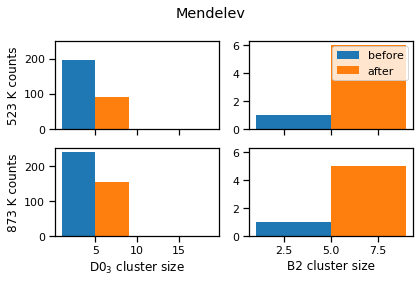

In [139]:
fig, axes = plot_histograms(0, threshold=13, clip=100, title='Mendelev', logy=False);
fig.savefig(
    'writeup/supplementary/figures/mendelev_hist_thresh13.eps', 
    format='eps'
)

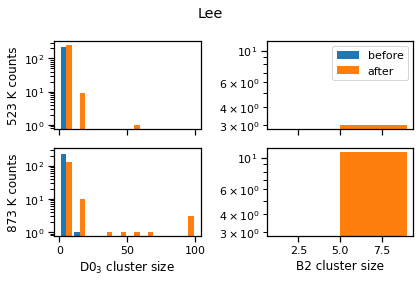

In [141]:
fig, axes = plot_histograms(2, threshold=13, clip=100, title='Lee', logy=True);
fig.savefig(
    'writeup/supplementary/figures/lee_hist_thresh13.eps', 
    format='eps'
)

Above, we compare the prevalence of clusters *before* and *after* annealing the random solid solution. In this way we can understand the prevalence of small clusters before annealing as a statistical baseline -- this is the amount of clustering that occurs with *no driving force for short range ordering* -- of course some configurations will randomly match the reference patterns! This is particularly true for D03 Fe sites, which do not require very much Al nearby to look D03-like.

For the Mendelev potential, this is both the begining and end of the story. We see a handful of small clusters (2 <= cluster size < 10), and some tendency for this to *increase slightly* with the MCMD annealing in the case of B2, but that's it.

For the Lee potential, which starts with a similar number of randomly identified small clusters (about 200, even though the exact initial condition is different for every simulation), but here there is strong evidence for cluster formation. For the cold (and poorly converged) 523 K simulation, one large (>50 atoms) cluster forms, and few small (10-20 atoms) clusters are present, so there is some evidence of phase decomposition, but not really SRO. On the other hand, at the higher temperature there are a few very large clusters (>100 atoms -- the binning is truncated here), as well as a whole handful of medium sized clusters (30-100 atoms).

We have full data fidelity, use a different clustering algorithm, and rely on an empirical potential, so a direct quantitative comparison with the experimental results is unwise. However, this potential clearly shows the same *qualitative* behaviour of D03 SRO. For the B2 phase we find almost nothing, but experimentally such clusters are also reported much, much less frequently.

Below we look at some of the raw clustering data, examining cluster sizes and count for that size. You can play around with the neighbour counting threshold both below and above in the plots. We found that requiring 13 of the 14 neighbours to match did a good job of resolving the interaction-driven clustering from the random identification of clusters.

In [27]:
clusters[13]['Lee 523K']['after'].stats

{'b2_0': array([[1, 2]]),
 'b2_1': array([[1, 1]]),
 'd03_0': array([[ 1, 55],
        [ 2,  1],
        [ 3,  3],
        [ 4,  2],
        [ 5,  2],
        [ 6,  2],
        [ 7,  3],
        [ 9,  1],
        [12,  1],
        [14,  1]]),
 'd03_1': array([[ 1, 58],
        [ 2,  2],
        [ 3,  3],
        [ 4,  4],
        [ 6,  1],
        [ 7,  1],
        [ 9,  1],
        [11,  1],
        [12,  1],
        [13,  1],
        [14,  1]]),
 'd03_2': array([[ 1, 59],
        [ 3,  4],
        [ 4,  2],
        [ 7,  1],
        [58,  1]]),
 'd03_3': array([[ 1, 45],
        [ 2,  1],
        [ 3,  2],
        [ 4,  2],
        [ 6,  1],
        [ 7,  2],
        [ 9,  2],
        [12,  1],
        [16,  2]])}

In [28]:
clusters[13]['Lee 873K']['after'].stats

{'b2_0': array([[1, 9]]),
 'b2_1': array([[1, 1],
        [2, 1]]),
 'd03_0': array([[ 1, 30],
        [ 2,  1],
        [ 3,  2],
        [ 4,  1],
        [ 5,  1],
        [11,  1],
        [14,  1],
        [15,  2],
        [43,  1]]),
 'd03_1': array([[ 1, 27],
        [ 2,  2],
        [ 3,  1],
        [ 4,  2],
        [ 5,  2],
        [13,  1],
        [68,  1],
        [99,  1]]),
 'd03_2': array([[  1,  24],
        [  2,   1],
        [  3,   3],
        [  7,   2],
        [ 10,   1],
        [ 14,   1],
        [ 58,   1],
        [118,   1]]),
 'd03_3': array([[  1,  20],
        [  3,   4],
        [  4,   2],
        [  5,   1],
        [  6,   2],
        [ 11,   1],
        [ 14,   1],
        [ 19,   1],
        [ 35,   1],
        [262,   1]])}

In [29]:
def _flat_ids(cluster, phase, i_list):
    try:
        return np.unique(
            np.concatenate([
                np.concatenate(cluster[f'{phase}_{i}'])
                for i in i_list
            ])
        )
    except ValueError:
        return []

def flat_d03_ids(cluster):
    return _flat_ids(cluster, 'd03', [0, 1, 2, 3])

def flat_b2_ids(cluster):
    return _flat_ids(cluster, 'b2', [0, 1])

def _chemistry_fractions(species):
    if len(species) < 1: 
        return None
    n = len(species)
    n_Al = np.sum(species == 'Al')
    return n_Al / n

def get_cluster_chemistry(cluster, job, frame=-1, threshold=12):
    species = job.get_structure(frame=frame).get_chemical_symbols()
    d03_ids = flat_d03_ids(cluster)
    b2_ids = flat_b2_ids(cluster)
    return (
        _chemistry_fractions(species[d03_ids]), 
        _chemistry_fractions(species[b2_ids])
    )

We can also peek at the nominal composition within the clusters. What we see is that all clusters tend to be richer in Al than their reference phase. This makes sense, since our alloy is Al-poor compared to the D03 reference, it is easier for your surroundings to look like D03 if you *are* an Al atom and expect to find mostly Fe neighbours than if you are an Fe atom and expect more Al neighbours.

Still, the Lee potential at 873 K comes closest to the nominal D03 concentration of 25%, which make sense since here we saw the strongest and largest clustering.

In [30]:
threshold = 13
hot_mendelev_Al_fractions = get_cluster_chemistry(
    clusters[threshold]['Mendelev 873K']['after'], 
    mcmd_jobs['Mendelev 873K'],
    threshold=threshold
)
print(hot_mendelev_Al_fractions)
hot_lee_Al_fractions = get_cluster_chemistry(
    clusters[threshold]['Lee 873K']['after'], 
    mcmd_jobs['Lee 873K'],
    threshold=threshold
)
print(hot_lee_Al_fractions)
cold_lee_Al_fractions = get_cluster_chemistry(
    clusters[threshold]['Lee 523K']['after'], 
    mcmd_jobs['Lee 523K'],
    threshold=threshold
)
print(cold_lee_Al_fractions)
# Hot Lee is much closer to the nominal compositions of 25 and 50% Al

(0.8877551020408163, None)
(0.4814453125, 0.9166666666666666)
(0.697324414715719, 1.0)


# Cluster visualization

We can straightforwardly see some of these effects by visualizing the largest cluster. By relaxing our clustering criteria a little bit for the Mendelev potential and looking at the largest B2 cluster, we can clearly see this potential's drive towards the columnar and planar Al organization

In [31]:
# Picking up that planar structure in Mendelev
a_job = mcmd_jobs['Mendelev 523K']
a_cluster = clusters[11]['Mendelev 523K']['after']['b2_1']
biggest_cluster = a_cluster[np.argmax([len(c) for c in a_cluster])]
pr.mcmd_sro.remap_species(a_job)[biggest_cluster].plot3d()

NGLWidget()

In [32]:
pr.mcmd_sro.remap_species(a_job).plot3d()

NGLWidget()

In [33]:
pr.mcmd_sro.remap_species(mcmd_jobs['Mendelev 873K']).plot3d()

NGLWidget()

In [34]:
# Mendelev is showing D03?! Not at strictness 13 it's not
a_job = mcmd_jobs['Mendelev 873K']
a_cluster = clusters[13]['Mendelev 873K']['after']['d03_3']
biggest_cluster = a_cluster[np.argmax([len(c) for c in a_cluster])]
pr.mcmd_sro.remap_species(a_job)[biggest_cluster].plot3d()

NGLWidget()

In contrast, with the same relaxed conditions the Lee potential shows a very normal looking B2 clusters.

Examining the Lee potential with the full 13/14 neighbours restriction, we can indeed see that at a higher temperature the largest D03 cluster is significantly bigger than at the cooler 523K condition, as observed in the histograms.

In [35]:
# In contrast, what does Lee show at the same conditions?
a_job = mcmd_jobs['Lee 523K']
a_cluster = clusters[11]['Lee 523K']['after']['b2_0']
biggest_cluster = a_cluster[np.argmax([len(c) for c in a_cluster])]
pr.mcmd_sro.remap_species(a_job)[biggest_cluster].plot3d()

NGLWidget()

In [36]:
# Biggest cluster for hot Lee
a_job = mcmd_jobs['Lee 873K']
a_cluster = clusters[13]['Lee 873K']['after']['d03_2']
biggest_cluster = a_cluster[np.argmax([len(c) for c in a_cluster])]
pr.mcmd_sro.remap_species(a_job)[biggest_cluster].plot3d()

NGLWidget()

In [37]:
# Not so big for cold Lee
a_job = mcmd_jobs['Lee 523K']
a_cluster = clusters[13]['Lee 523K']['after']['d03_3']
biggest_cluster = a_cluster[np.argmax([len(c) for c in a_cluster])]
pr.mcmd_sro.remap_species(a_job)[biggest_cluster].plot3d()

NGLWidget()

# MCMD convergence

Finally, let's revisit the topic of slow convergence for the Lee potential at 523 K. Informed by our 0K calculations that the system probably wants full phase decomposition with nearly 0\% Al in the BCC phase, we can use *this* as the starting point for our MCMD instead of a random solid solution.

To accomplish this we just build a pure-Fe BCC cell containing a (roughly!) spherical D03 precipitate, and scale the size of this precipitate to get the desired 18\% nominal Al concentration.

In [38]:
def create_decomposed_structure(
    target=0.18, 
    repeat=pr.create.structure.FeAl.supercell_repeats.four_nm_cube
):
    pre_decomposed = pr.create.structure.FeAl.bcc(repeat=repeat)
    d03_species = pr.create.structure.FeAl.d03(repeat=repeat).get_chemical_symbols()
    topology = pre_decomposed.get_neighbors(num_neighbors=14).indices
    
    def get_c_Al(structure):
        return np.sum(structure.get_chemical_symbols() == 'Al') / len(structure) 

    def target_Al_reached(i, j):
        if get_c_Al(pre_decomposed) < target:
            pre_decomposed[j] = d03_species[j]
        c_Al = get_c_Al(pre_decomposed)
        return c_Al < target

    from pyiron_feal.utils import bfs
    bfs(0, topology, target_Al_reached)
    
    return pre_decomposed

In [39]:
pre_decomposed_structure = create_decomposed_structure()

In [40]:
pre_decomposed_cold = pr.create.job.mcmd.small_cube(
    temperature=523, 
    potl_index=2,
    n_ionic_steps=1e5,
    n_print=1e4,
    name_override='lee_523_predecomposed'
)
pre_decomposed_cold.structure = pre_decomposed_structure.copy()
pre_decomposed_cold.server.queue = SERVER
pre_decomposed_cold.run()

2021-10-13 15:06:35,494 - pyiron_log - WARNING - The job lee_523_predecomposed is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


In [41]:
pre_decomposed_hot = pr.create.job.mcmd.small_cube(
    temperature=873, 
    potl_index=2,
    n_ionic_steps=1e5,
    n_print=1e4,
    name_override='lee_873_predecomposed'
)
pre_decomposed_hot.structure = pre_decomposed_structure.copy()
pre_decomposed_hot.server.queue = SERVER
pre_decomposed_hot.run()

2021-10-13 15:06:36,387 - pyiron_log - WARNING - The job lee_873_predecomposed is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


The energy plots are not super informative, but indeed we no longer see the strong trend of energy vs time as for the very unhappy 523 K Lee simulation starting from random solution.

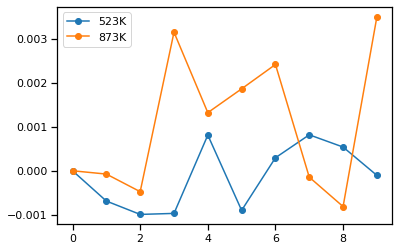

In [42]:
plt.plot(
    (pre_decomposed_cold.output.energy_pot[1:] - pre_decomposed_cold.output.energy_pot[1]) / len(pre_decomposed_structure), 
    marker='o', 
    label='523K'
)
plt.plot(
    (pre_decomposed_hot.output.energy_pot[1:] - pre_decomposed_hot.output.energy_pot[1]) / len(pre_decomposed_structure), 
    marker='o', 
    label='873K'
)
plt.legend()

We hypothesize that at the lower temperature, except for some adjustment in the *shape* of the precipitate, the system should already be quite happy. Meanwhile, at a higher temperature we expect some of the Al to wind up in the solid solution, and we might also expect the precipitate to break apart into smaller chunks (more smaller clusters favouring entropy over energy -- i.e. SRO). Indeed, by plotting the cluster histograms as a function of MCMD time this is what we see.

For 523 K there is a stable second cluster around 40 atoms in size, but the other small clusters are transient and condense into either the initial cluster or this smaller one.

In contrast, for 873 K we do see a large secondary cluster (around 70 atoms), but at the end (i.e. darkest red) there are still quite a few smaller (10-50 atom) clusters available. The random solution is a much better starting point for this temperature and the simulation here is likely not fully converged, but the general trend of the single large precipitate breaking apart is exactly what we see.

In [43]:
pre_decomposed_clusters = {'cold': [], 'hot': []}
for job, key in zip([pre_decomposed_cold, pre_decomposed_hot], pre_decomposed_clusters.keys()):
    for frame in range(len(job.output.energy_pot)):
        chemistry = job.get_structure(frame).get_chemical_symbols()
        pre_decomposed_clusters[key].append(pr.mcmd_sro.cluster(chemistry))

In [149]:
def plot_pre_decomposed_hist(
    ax, 
    clusters, 
    binsize=10, 
    maxsize=None, 
    title=None, 
    logy=True,
    **hist_kwargs
):
    clusters = [clusts.d03 for clusts in clusters]
    if ax is None:
        _, ax = plt.subplots()
    biggest = np.amax([np.amax(c) for c in clusters]) if maxsize is None else maxsize
    divisions = int(biggest/binsize)
    ax.hist(
        clusters, 
        bins=np.arange(biggest + binsize, step=binsize), # np.logspace(2, biggest, num=divisions + 1), #
        **hist_kwargs
    )
    if logy:
        ax.set_yscale('log')
    # ax.set_xscale('log')
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel('Cluster count')
    return ax

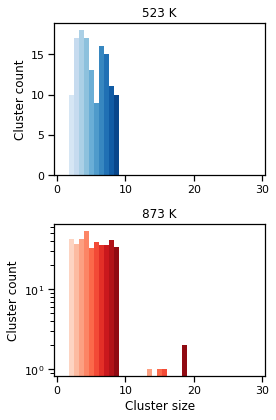

In [151]:
fig, axes  = plt.subplots(nrows=2, figsize=(4,6))
maxsize = 30
plot_pre_decomposed_hist(
    axes[0], 
    pre_decomposed_clusters['cold'], 
    maxsize=maxsize, 
    title='523 K', 
    logy=False,
    color=sns.color_palette('Blues', n_colors=len(pre_decomposed_clusters['cold'])), 
)
plot_pre_decomposed_hist(
    axes[1], 
    pre_decomposed_clusters['hot'], 
    maxsize=maxsize, 
    title='873 K', 
    logy=True,
    color=sns.color_palette('Reds', n_colors=len(pre_decomposed_clusters['hot'])), 
)
axes[1].set_xlabel('Cluster size')
fig.tight_layout()
fig.savefig('writeup/supplementary/figures/decomposing_clusters.eps', fmt='eps')

We can also peek at what sort of Al concentration we wind up with in the solid solution. Of course to begin with it's zero by construction.

In [46]:
def get_solid_solution_Al_fraction(structure, clusters):
    """That's not in the given cluster"""
    d03_ids = np.concatenate(tuple([vv for k, v in clusters.data.items() if 'd03' in k and len(v) > 0 for vv in v]))

    Al_tot = np.sum(structure.get_chemical_symbols() == 'Al')
    Al_clust = np.sum(structure[np.unique(d03_ids)].get_chemical_symbols() == 'Al')
    Al_ss = Al_tot - Al_clust
    sites_ss = len(structure) - len(d03_ids)
    return Al_ss / sites_ss

In [47]:
for job, (k, clusters) in zip(
    [pre_decomposed_cold, pre_decomposed_hot], 
    pre_decomposed_clusters.items()
):
    print(k)
    print(f"solid solution Al before = {get_solid_solution_Al_fraction(job.get_structure(0), clusters[0])}")
    print(f"solid solution Al after = {get_solid_solution_Al_fraction(job.get_structure(-1), clusters[-1])}")

cold
solid solution Al before = 0.0
solid solution Al after = 0.0
hot
solid solution Al before = 0.0
solid solution Al after = 0.03977695167286245


Ok, according to our clustering algorithm the final solid solution Al concentration is even lower than our 0K potential energy "phase diagram" might have predicted, but at 4\% it's at least very very roughly in the right ball park. Again, the qualitative trend that the solid solution concentration is much higher at the higher temperature (still ZERO for 523 K!) is spot on.

Let's just look at the final cluster sizes directly

In [48]:
pre_decomposed_clusters['cold'][-1].d03

array([3638,    1,    1,    1,    1,    1,    1,    4,    1,    1,    1])

In [49]:
pre_decomposed_clusters['hot'][-1].d03

array([2726,    1,    1,    1,    1,    1,    3,    1,    4,   12,    1,
          1,   12,    1,    8,    3,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1])

In [50]:
pre_decomposed_clusters['cold'][-1].b2

array([], dtype=int64)

In [51]:
pre_decomposed_clusters['hot'][-1].b2

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [52]:
pr.job_table()['totalcputime'].values.sum() / 3600

137.26416666666665

# Cluster turnover

As a sanity check on our hypothesis that at high temperatures it is entropy driving perfect phase decomposition towards more and smaller D03 clusters, let's check the turnover in cluster makeup as a function of time. If we are in a regime of (slow) Ostwald ripening, we can expect clusters to contain more or less the same sites from snapshot to snapshot. On the other hand, if, as we suspect, clusters form somewhat spontaneously due to the higher solid solution Al content and are prevented (due to the entropic benefit of breaking up clusters) from forming critical nuclii and undergoing full phase decomposition, then we should see pretty high turnover in which sites are making up the D03 clusters.

In [62]:
through_time = {}
for job_key in ['Lee 523K', 'Lee 873K']:
    through_time[job_key] = {}
    job = mcmd_jobs[job_key]
    for n in np.arange(len(job.output.energy_pot)):
        through_time[job_key][n] = pr.mcmd_sro.cluster(
            job.get_structure(n).get_chemical_symbols(),
            threshold=13
        )

In [71]:
def get_all_phase_ids(cluster, phase='d03'):
    return np.concatenate([
        np.concatenate(id_list) 
        for k, id_list in cluster.data.items() 
        if phase in k
    ])

In [86]:
def compare_sets(new_set, old_set):
    union = np.union1d(now, before)
    diff = np.setdiff1d(now, before)
    return [len(now), len(diff)]

In [87]:
turnover_stats = {}
for k, dict_ in through_time.items():
    before = get_all_phase_ids(dict_[0])
    stats = []
    for n in np.arange(1, len(dict_)):
        now = get_all_phase_ids(dict_[n])
        stats.append(compare_sets(now, before))
        before = now
    turnover_stats[k] = np.array(stats).T

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


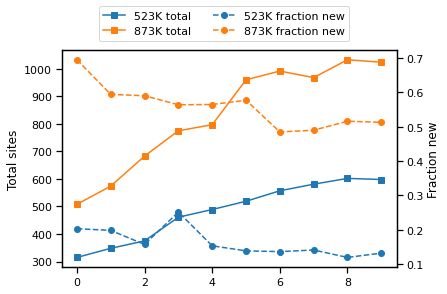

In [153]:
fig, ax_total = plt.subplots()
ax_turnover = ax_total.twinx()
colors_ = sns.color_palette(n_colors=2)

for c, (k, v) in zip(colors_, turnover_stats.items()):
    T = k.split(' ')[-1]
    ax_turnover.plot(v[1] / v[0], label=T + ' fraction new', marker='o', linestyle='--', color=c)
    ax_total.plot(v[0], label=T + ' total', marker='s', color=c)
ax_turnover.set_xlabel('Dump frame')
ax_turnover.set_ylabel('Fraction new')
ax_total.set_ylabel('Total sites')
fig.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.05))
# fig.tight_layout()
fig.savefig('writeup/supplementary/figures/cluster_turnover.eps', fmt='eps')

# Conclusion

We'll be very brief here since most of it's in the writeup: for the Lee potential at the higher temperature (873 K) we do indeed see a strong tendency towards a bunch of small and medium sized D03 clusters -- i.e. SRO. At the colder temperature (523 K) these are absent. From the 0K potential energies (and including configurational entropy) we can understand this fairly well: at the lower temperature the miscibility gap between the solid solution and D03 is huge (at least for this potential) and there is hardly any Al left in the solution to form these smaller clusters, and we wind up with a driving force towards fewer, larger D03 precipitates. In contrast, at higher temperature we have both more Al in the solution, giving potential clusters some material to work with, and an entropic drive towards more but smaller clusters, i.e. SRO. This perspective is supported by the high turnover of which atoms make up the clusters at high temperature.